<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[16:10:13] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


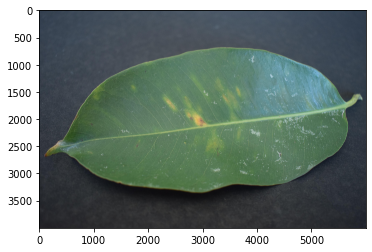

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

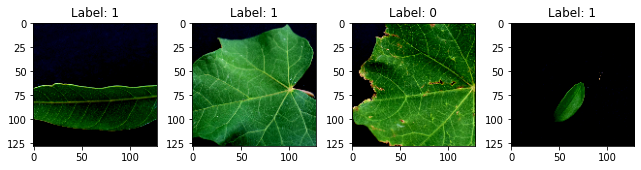

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[16:10:21] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[16:10:23] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2567329140232568 samples/sec                   batch loss = 0.5051131844520569 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2619585145411825 samples/sec                   batch loss = 0.6643786430358887 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.268994278442669 samples/sec                   batch loss = 0.39600270986557007 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2698032681743503 samples/sec                   batch loss = 1.1706024408340454 | accuracy = 0.45


Epoch[1] Batch[25] Speed: 1.2630408968686972 samples/sec                   batch loss = 0.5799418687820435 | accuracy = 0.49


Epoch[1] Batch[30] Speed: 1.270861417365302 samples/sec                   batch loss = 0.6627312898635864 | accuracy = 0.5166666666666667


Epoch[1] Batch[35] Speed: 1.2711469125211095 samples/sec                   batch loss = 1.3989681005477905 | accuracy = 0.5285714285714286


Epoch[1] Batch[40] Speed: 1.274728731386575 samples/sec                   batch loss = 0.5581951141357422 | accuracy = 0.53125


Epoch[1] Batch[45] Speed: 1.2808887025345497 samples/sec                   batch loss = 0.22262626886367798 | accuracy = 0.5666666666666667


Epoch[1] Batch[50] Speed: 1.2796538045966264 samples/sec                   batch loss = 0.8954100012779236 | accuracy = 0.58


Epoch[1] Batch[55] Speed: 1.2722464715463924 samples/sec                   batch loss = 1.1387948989868164 | accuracy = 0.5909090909090909


Epoch[1] Batch[60] Speed: 1.2774088692012442 samples/sec                   batch loss = 1.1187373399734497 | accuracy = 0.5958333333333333


Epoch[1] Batch[65] Speed: 1.2769888386508041 samples/sec                   batch loss = 0.336123526096344 | accuracy = 0.6076923076923076


Epoch[1] Batch[70] Speed: 1.2712715499424765 samples/sec                   batch loss = 0.8189381957054138 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.2649389920020424 samples/sec                   batch loss = 0.7099629044532776 | accuracy = 0.6266666666666667


Epoch[1] Batch[80] Speed: 1.2722335437947696 samples/sec                   batch loss = 0.6233850121498108 | accuracy = 0.61875


Epoch[1] Batch[85] Speed: 1.2739647243048868 samples/sec                   batch loss = 0.2675066590309143 | accuracy = 0.6294117647058823


Epoch[1] Batch[90] Speed: 1.2665356186192305 samples/sec                   batch loss = 0.7548566460609436 | accuracy = 0.6333333333333333


Epoch[1] Batch[95] Speed: 1.2643718804661317 samples/sec                   batch loss = 0.8077167272567749 | accuracy = 0.6394736842105263


Epoch[1] Batch[100] Speed: 1.2652266028850445 samples/sec                   batch loss = 0.28666889667510986 | accuracy = 0.645


Epoch[1] Batch[105] Speed: 1.2697587724011867 samples/sec                   batch loss = 0.39762189984321594 | accuracy = 0.6357142857142857


Epoch[1] Batch[110] Speed: 1.271759643326687 samples/sec                   batch loss = 0.8648154735565186 | accuracy = 0.6363636363636364


Epoch[1] Batch[115] Speed: 1.268109250547785 samples/sec                   batch loss = 0.26216402649879456 | accuracy = 0.6434782608695652


Epoch[1] Batch[120] Speed: 1.270736956595011 samples/sec                   batch loss = 0.381290465593338 | accuracy = 0.6416666666666667


Epoch[1] Batch[125] Speed: 1.2693728567739582 samples/sec                   batch loss = 0.32498666644096375 | accuracy = 0.652


Epoch[1] Batch[130] Speed: 1.2739417011933303 samples/sec                   batch loss = 0.6146562099456787 | accuracy = 0.6596153846153846


Epoch[1] Batch[135] Speed: 1.2732615407336372 samples/sec                   batch loss = 0.5198373794555664 | accuracy = 0.6592592592592592


Epoch[1] Batch[140] Speed: 1.2676854463847063 samples/sec                   batch loss = 0.4869990944862366 | accuracy = 0.6589285714285714


Epoch[1] Batch[145] Speed: 1.279898933761868 samples/sec                   batch loss = 0.5605940222740173 | accuracy = 0.6620689655172414


Epoch[1] Batch[150] Speed: 1.2669357879416783 samples/sec                   batch loss = 1.0699068307876587 | accuracy = 0.6616666666666666


Epoch[1] Batch[155] Speed: 1.2683392371041868 samples/sec                   batch loss = 0.44117334485054016 | accuracy = 0.6629032258064517


Epoch[1] Batch[160] Speed: 1.274806412686839 samples/sec                   batch loss = 0.9749569892883301 | accuracy = 0.65625


Epoch[1] Batch[165] Speed: 1.2703071624806204 samples/sec                   batch loss = 1.4219956398010254 | accuracy = 0.65


Epoch[1] Batch[170] Speed: 1.26662091076096 samples/sec                   batch loss = 0.28781235218048096 | accuracy = 0.6514705882352941


Epoch[1] Batch[175] Speed: 1.2727525002774651 samples/sec                   batch loss = 0.32941633462905884 | accuracy = 0.6557142857142857


Epoch[1] Batch[180] Speed: 1.266772016968501 samples/sec                   batch loss = 0.16206128895282745 | accuracy = 0.6597222222222222


Epoch[1] Batch[185] Speed: 1.2715229218291384 samples/sec                   batch loss = 0.49572399258613586 | accuracy = 0.6608108108108108


Epoch[1] Batch[190] Speed: 1.2799770511927009 samples/sec                   batch loss = 0.6071023344993591 | accuracy = 0.6605263157894737


Epoch[1] Batch[195] Speed: 1.2730668595452834 samples/sec                   batch loss = 1.1928292512893677 | accuracy = 0.658974358974359


Epoch[1] Batch[200] Speed: 1.2722860282391233 samples/sec                   batch loss = 0.7947062849998474 | accuracy = 0.6625


Epoch[1] Batch[205] Speed: 1.2683325251852655 samples/sec                   batch loss = 0.6388542652130127 | accuracy = 0.6560975609756098


Epoch[1] Batch[210] Speed: 1.2686623561789685 samples/sec                   batch loss = 0.67914217710495 | accuracy = 0.6523809523809524


Epoch[1] Batch[215] Speed: 1.265953414691254 samples/sec                   batch loss = 0.5141394138336182 | accuracy = 0.6523255813953488


Epoch[1] Batch[220] Speed: 1.2751898242727893 samples/sec                   batch loss = 1.1002072095870972 | accuracy = 0.6511363636363636


Epoch[1] Batch[225] Speed: 1.274656482715168 samples/sec                   batch loss = 0.5320421457290649 | accuracy = 0.6477777777777778


Epoch[1] Batch[230] Speed: 1.271764077876411 samples/sec                   batch loss = 1.1008415222167969 | accuracy = 0.6456521739130435


Epoch[1] Batch[235] Speed: 1.2763324139374892 samples/sec                   batch loss = 0.985806405544281 | accuracy = 0.6393617021276595


Epoch[1] Batch[240] Speed: 1.2731729365029014 samples/sec                   batch loss = 0.6899543404579163 | accuracy = 0.6385416666666667


Epoch[1] Batch[245] Speed: 1.276142713773021 samples/sec                   batch loss = 0.2669594883918762 | accuracy = 0.6408163265306123


Epoch[1] Batch[250] Speed: 1.2717033465143481 samples/sec                   batch loss = 0.3516038656234741 | accuracy = 0.644


Epoch[1] Batch[255] Speed: 1.277153026037996 samples/sec                   batch loss = 0.316461980342865 | accuracy = 0.6450980392156863


Epoch[1] Batch[260] Speed: 1.2762566824417274 samples/sec                   batch loss = 0.3997954726219177 | accuracy = 0.6471153846153846


Epoch[1] Batch[265] Speed: 1.274811159108092 samples/sec                   batch loss = 0.5195233821868896 | accuracy = 0.6462264150943396


Epoch[1] Batch[270] Speed: 1.2813078779677833 samples/sec                   batch loss = 0.97397381067276 | accuracy = 0.6472222222222223


Epoch[1] Batch[275] Speed: 1.2691274223988538 samples/sec                   batch loss = 0.6359742879867554 | accuracy = 0.6463636363636364


Epoch[1] Batch[280] Speed: 1.2712684674240229 samples/sec                   batch loss = 0.4182303547859192 | accuracy = 0.6482142857142857


Epoch[1] Batch[285] Speed: 1.2742666168622714 samples/sec                   batch loss = 0.32153719663619995 | accuracy = 0.6491228070175439


Epoch[1] Batch[290] Speed: 1.272036187018832 samples/sec                   batch loss = 0.6674884557723999 | accuracy = 0.6474137931034483


Epoch[1] Batch[295] Speed: 1.2772835117208305 samples/sec                   batch loss = 0.3132512867450714 | accuracy = 0.6508474576271186


Epoch[1] Batch[300] Speed: 1.2777052930756378 samples/sec                   batch loss = 0.6549739837646484 | accuracy = 0.6508333333333334


Epoch[1] Batch[305] Speed: 1.2751678229828085 samples/sec                   batch loss = 0.45337897539138794 | accuracy = 0.6524590163934426


Epoch[1] Batch[310] Speed: 1.2795985634389602 samples/sec                   batch loss = 0.5019807815551758 | accuracy = 0.6540322580645161


Epoch[1] Batch[315] Speed: 1.2768508333671371 samples/sec                   batch loss = 0.33971890807151794 | accuracy = 0.6547619047619048


Epoch[1] Batch[320] Speed: 1.2756915045529518 samples/sec                   batch loss = 0.4106607139110565 | accuracy = 0.6546875


Epoch[1] Batch[325] Speed: 1.2732352577124149 samples/sec                   batch loss = 0.4712353050708771 | accuracy = 0.6569230769230769


Epoch[1] Batch[330] Speed: 1.2736271031524464 samples/sec                   batch loss = 0.46814247965812683 | accuracy = 0.6575757575757576


Epoch[1] Batch[335] Speed: 1.271260472211454 samples/sec                   batch loss = 0.6628823280334473 | accuracy = 0.6567164179104478


Epoch[1] Batch[340] Speed: 1.2726701454710685 samples/sec                   batch loss = 0.1837468296289444 | accuracy = 0.6602941176470588


Epoch[1] Batch[345] Speed: 1.2758386704254638 samples/sec                   batch loss = 0.9883432984352112 | accuracy = 0.6630434782608695


Epoch[1] Batch[350] Speed: 1.2665442238075693 samples/sec                   batch loss = 0.43215999007225037 | accuracy = 0.6635714285714286


Epoch[1] Batch[355] Speed: 1.274117684673109 samples/sec                   batch loss = 0.7083014845848083 | accuracy = 0.6647887323943662


Epoch[1] Batch[360] Speed: 1.2681696391080732 samples/sec                   batch loss = 0.41297203302383423 | accuracy = 0.6659722222222222


Epoch[1] Batch[365] Speed: 1.2709973606140588 samples/sec                   batch loss = 0.552269697189331 | accuracy = 0.6678082191780822


Epoch[1] Batch[370] Speed: 1.2747958544479523 samples/sec                   batch loss = 0.7382309436798096 | accuracy = 0.6655405405405406


Epoch[1] Batch[375] Speed: 1.2742294531342209 samples/sec                   batch loss = 0.4480270743370056 | accuracy = 0.6653333333333333


Epoch[1] Batch[380] Speed: 1.269586008444829 samples/sec                   batch loss = 0.09340900182723999 | accuracy = 0.6684210526315789


Epoch[1] Batch[385] Speed: 1.2749281840991746 samples/sec                   batch loss = 0.574762225151062 | accuracy = 0.6681818181818182


Epoch[1] Batch[390] Speed: 1.2715030705301107 samples/sec                   batch loss = 1.5721991062164307 | accuracy = 0.6685897435897435


Epoch[1] Batch[395] Speed: 1.2694772623712474 samples/sec                   batch loss = 0.640390932559967 | accuracy = 0.6683544303797468


Epoch[1] Batch[400] Speed: 1.2719600001516294 samples/sec                   batch loss = 0.2608543932437897 | accuracy = 0.6675


Epoch[1] Batch[405] Speed: 1.2712254100571676 samples/sec                   batch loss = 0.4609125852584839 | accuracy = 0.6685185185185185


Epoch[1] Batch[410] Speed: 1.2694571867323494 samples/sec                   batch loss = 0.30010706186294556 | accuracy = 0.6701219512195122


Epoch[1] Batch[415] Speed: 1.272217143293924 samples/sec                   batch loss = 0.3673819899559021 | accuracy = 0.6710843373493975


Epoch[1] Batch[420] Speed: 1.2726621326180767 samples/sec                   batch loss = 0.3545580506324768 | accuracy = 0.6726190476190477


Epoch[1] Batch[425] Speed: 1.2662468389521102 samples/sec                   batch loss = 1.0984888076782227 | accuracy = 0.6723529411764706


Epoch[1] Batch[430] Speed: 1.264579638396838 samples/sec                   batch loss = 0.7479080557823181 | accuracy = 0.6732558139534883


Epoch[1] Batch[435] Speed: 1.2595285293390095 samples/sec                   batch loss = 0.3926525115966797 | accuracy = 0.6735632183908046


Epoch[1] Batch[440] Speed: 1.259321671440698 samples/sec                   batch loss = 0.8595415353775024 | accuracy = 0.675


Epoch[1] Batch[445] Speed: 1.2611932371685557 samples/sec                   batch loss = 0.3129469156265259 | accuracy = 0.6764044943820224


Epoch[1] Batch[450] Speed: 1.257886883708404 samples/sec                   batch loss = 0.4936743974685669 | accuracy = 0.6777777777777778


Epoch[1] Batch[455] Speed: 1.2631862044404825 samples/sec                   batch loss = 0.5341871380805969 | accuracy = 0.6780219780219781


Epoch[1] Batch[460] Speed: 1.263584259695043 samples/sec                   batch loss = 1.305834412574768 | accuracy = 0.6798913043478261


Epoch[1] Batch[465] Speed: 1.2615244872608495 samples/sec                   batch loss = 0.24892780184745789 | accuracy = 0.6806451612903226


Epoch[1] Batch[470] Speed: 1.2650196815587509 samples/sec                   batch loss = 0.7447641491889954 | accuracy = 0.6797872340425531


Epoch[1] Batch[475] Speed: 1.2727161006489502 samples/sec                   batch loss = 0.522595226764679 | accuracy = 0.68


Epoch[1] Batch[480] Speed: 1.2719399423422955 samples/sec                   batch loss = 0.4135962426662445 | accuracy = 0.6791666666666667


Epoch[1] Batch[485] Speed: 1.2800415052520548 samples/sec                   batch loss = 0.24259918928146362 | accuracy = 0.6804123711340206


Epoch[1] Batch[490] Speed: 1.2752907297811784 samples/sec                   batch loss = 0.43892982602119446 | accuracy = 0.6811224489795918


Epoch[1] Batch[495] Speed: 1.2694309644857482 samples/sec                   batch loss = 0.4927447736263275 | accuracy = 0.6823232323232323


Epoch[1] Batch[500] Speed: 1.2697765511157384 samples/sec                   batch loss = 0.4556695222854614 | accuracy = 0.6815


Epoch[1] Batch[505] Speed: 1.2702907154278784 samples/sec                   batch loss = 0.45764026045799255 | accuracy = 0.6816831683168317


Epoch[1] Batch[510] Speed: 1.2695059841261205 samples/sec                   batch loss = 0.19910970330238342 | accuracy = 0.6823529411764706


Epoch[1] Batch[515] Speed: 1.2694102179813422 samples/sec                   batch loss = 0.3026115298271179 | accuracy = 0.683495145631068


Epoch[1] Batch[520] Speed: 1.2717525095507178 samples/sec                   batch loss = 0.4071968197822571 | accuracy = 0.6836538461538462


Epoch[1] Batch[525] Speed: 1.2777440222044483 samples/sec                   batch loss = 1.6715197563171387 | accuracy = 0.680952380952381


Epoch[1] Batch[530] Speed: 1.2707894138855644 samples/sec                   batch loss = 0.5764078497886658 | accuracy = 0.6811320754716981


Epoch[1] Batch[535] Speed: 1.2746148417593302 samples/sec                   batch loss = 0.46055030822753906 | accuracy = 0.6831775700934579


Epoch[1] Batch[540] Speed: 1.2711962251784839 samples/sec                   batch loss = 0.6340243220329285 | accuracy = 0.6847222222222222


Epoch[1] Batch[545] Speed: 1.2728503164900768 samples/sec                   batch loss = 0.35341769456863403 | accuracy = 0.6839449541284404


Epoch[1] Batch[550] Speed: 1.27758376891726 samples/sec                   batch loss = 0.27059459686279297 | accuracy = 0.6854545454545454


Epoch[1] Batch[555] Speed: 1.2665894507751712 samples/sec                   batch loss = 0.4115930199623108 | accuracy = 0.6864864864864865


Epoch[1] Batch[560] Speed: 1.271553278169484 samples/sec                   batch loss = 0.23276929557323456 | accuracy = 0.6875


Epoch[1] Batch[565] Speed: 1.2667608262221628 samples/sec                   batch loss = 0.30075153708457947 | accuracy = 0.6880530973451328


Epoch[1] Batch[570] Speed: 1.271737181843341 samples/sec                   batch loss = 0.14013251662254333 | accuracy = 0.6890350877192982


Epoch[1] Batch[575] Speed: 1.2708401427606941 samples/sec                   batch loss = 0.36619317531585693 | accuracy = 0.6895652173913044


Epoch[1] Batch[580] Speed: 1.2705369848577297 samples/sec                   batch loss = 0.1723039597272873 | accuracy = 0.690948275862069


Epoch[1] Batch[585] Speed: 1.272465125408671 samples/sec                   batch loss = 0.755007266998291 | accuracy = 0.6914529914529914


Epoch[1] Batch[590] Speed: 1.2625193773948955 samples/sec                   batch loss = 0.7276769280433655 | accuracy = 0.690677966101695


Epoch[1] Batch[595] Speed: 1.2616378521074465 samples/sec                   batch loss = 0.7329841256141663 | accuracy = 0.6899159663865546


Epoch[1] Batch[600] Speed: 1.2687224136586792 samples/sec                   batch loss = 0.24683667719364166 | accuracy = 0.6916666666666667


Epoch[1] Batch[605] Speed: 1.2725047922154686 samples/sec                   batch loss = 0.4594772160053253 | accuracy = 0.6925619834710743


Epoch[1] Batch[610] Speed: 1.277269022799381 samples/sec                   batch loss = 0.8338050246238708 | accuracy = 0.6918032786885245


Epoch[1] Batch[615] Speed: 1.2760700135622052 samples/sec                   batch loss = 0.1904144287109375 | accuracy = 0.6934959349593496


Epoch[1] Batch[620] Speed: 1.268419210289358 samples/sec                   batch loss = 0.27394986152648926 | accuracy = 0.6935483870967742


Epoch[1] Batch[625] Speed: 1.2714696330928583 samples/sec                   batch loss = 0.5176993608474731 | accuracy = 0.6936


Epoch[1] Batch[630] Speed: 1.2691506558580834 samples/sec                   batch loss = 1.9237967729568481 | accuracy = 0.6928571428571428


Epoch[1] Batch[635] Speed: 1.2670109913695287 samples/sec                   batch loss = 0.5485630631446838 | accuracy = 0.6921259842519685


Epoch[1] Batch[640] Speed: 1.262230906661645 samples/sec                   batch loss = 0.19439652562141418 | accuracy = 0.694140625


Epoch[1] Batch[645] Speed: 1.26612098714357 samples/sec                   batch loss = 0.8846734762191772 | accuracy = 0.6934108527131783


Epoch[1] Batch[650] Speed: 1.2634250645786622 samples/sec                   batch loss = 0.32715797424316406 | accuracy = 0.6934615384615385


Epoch[1] Batch[655] Speed: 1.2634657873051978 samples/sec                   batch loss = 0.4155151844024658 | accuracy = 0.6938931297709924


Epoch[1] Batch[660] Speed: 1.2657555185121057 samples/sec                   batch loss = 0.4053385257720947 | accuracy = 0.6946969696969697


Epoch[1] Batch[665] Speed: 1.2655702856944573 samples/sec                   batch loss = 0.3020264208316803 | accuracy = 0.6943609022556391


Epoch[1] Batch[670] Speed: 1.2674774328159486 samples/sec                   batch loss = 0.3613726794719696 | accuracy = 0.692910447761194


Epoch[1] Batch[675] Speed: 1.2662560136385874 samples/sec                   batch loss = 0.50648432970047 | accuracy = 0.6940740740740741


Epoch[1] Batch[680] Speed: 1.2651812823752193 samples/sec                   batch loss = 0.6903149485588074 | accuracy = 0.6948529411764706


Epoch[1] Batch[685] Speed: 1.2623932205307928 samples/sec                   batch loss = 1.0408873558044434 | accuracy = 0.6945255474452555


Epoch[1] Batch[690] Speed: 1.266779477575906 samples/sec                   batch loss = 0.5060338973999023 | accuracy = 0.6949275362318841


Epoch[1] Batch[695] Speed: 1.2726354881939679 samples/sec                   batch loss = 0.40423527359962463 | accuracy = 0.6949640287769784


Epoch[1] Batch[700] Speed: 1.2709655865706795 samples/sec                   batch loss = 0.6413882374763489 | accuracy = 0.6960714285714286


Epoch[1] Batch[705] Speed: 1.2668365828276347 samples/sec                   batch loss = 0.4438491463661194 | accuracy = 0.6971631205673758


Epoch[1] Batch[710] Speed: 1.2678454295882915 samples/sec                   batch loss = 0.45618581771850586 | accuracy = 0.6975352112676056


Epoch[1] Batch[715] Speed: 1.2704966709432512 samples/sec                   batch loss = 0.48872774839401245 | accuracy = 0.6961538461538461


Epoch[1] Batch[720] Speed: 1.2662291589416763 samples/sec                   batch loss = 0.5613203048706055 | accuracy = 0.6961805555555556


Epoch[1] Batch[725] Speed: 1.2665563668833708 samples/sec                   batch loss = 0.5297539830207825 | accuracy = 0.6972413793103448


Epoch[1] Batch[730] Speed: 1.2644979566075594 samples/sec                   batch loss = 0.4456422030925751 | accuracy = 0.696917808219178


Epoch[1] Batch[735] Speed: 1.2668847962944645 samples/sec                   batch loss = 0.7690485715866089 | accuracy = 0.6972789115646258


Epoch[1] Batch[740] Speed: 1.2628659635245167 samples/sec                   batch loss = 0.5966086983680725 | accuracy = 0.6976351351351351


Epoch[1] Batch[745] Speed: 1.2671552040836056 samples/sec                   batch loss = 0.444857656955719 | accuracy = 0.6973154362416107


Epoch[1] Batch[750] Speed: 1.2612012010612386 samples/sec                   batch loss = 0.44687795639038086 | accuracy = 0.698


Epoch[1] Batch[755] Speed: 1.2557112157361485 samples/sec                   batch loss = 0.4355818033218384 | accuracy = 0.6990066225165563


Epoch[1] Batch[760] Speed: 1.2611655539431306 samples/sec                   batch loss = 0.7328618764877319 | accuracy = 0.7


Epoch[1] Batch[765] Speed: 1.2671751112700924 samples/sec                   batch loss = 0.5038386583328247 | accuracy = 0.7


Epoch[1] Batch[770] Speed: 1.2695085777933823 samples/sec                   batch loss = 0.4623592793941498 | accuracy = 0.7006493506493506


Epoch[1] Batch[775] Speed: 1.2654521087567299 samples/sec                   batch loss = 0.315599262714386 | accuracy = 0.7


Epoch[1] Batch[780] Speed: 1.2698241236381185 samples/sec                   batch loss = 0.9047820568084717 | accuracy = 0.7


Epoch[1] Batch[785] Speed: 1.2676581478949718 samples/sec                   batch loss = 0.37857702374458313 | accuracy = 0.7009554140127389


[Epoch 1] training: accuracy=0.7011421319796954
[Epoch 1] time cost: 648.0090448856354
[Epoch 1] validation: validation accuracy=0.7422222222222222


Epoch[2] Batch[5] Speed: 1.2721708382798003 samples/sec                   batch loss = 0.6849480271339417 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.268691616700809 samples/sec                   batch loss = 0.3569774627685547 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2673866637618199 samples/sec                   batch loss = 0.18890543282032013 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.2704627091774359 samples/sec                   batch loss = 0.43562695384025574 | accuracy = 0.8


Epoch[2] Batch[25] Speed: 1.2720219133413722 samples/sec                   batch loss = 0.11668567359447479 | accuracy = 0.8


Epoch[2] Batch[30] Speed: 1.2742427118197117 samples/sec                   batch loss = 0.27449366450309753 | accuracy = 0.8166666666666667


Epoch[2] Batch[35] Speed: 1.2714149999120925 samples/sec                   batch loss = 0.24851316213607788 | accuracy = 0.8142857142857143


Epoch[2] Batch[40] Speed: 1.2710682320825402 samples/sec                   batch loss = 0.6972910761833191 | accuracy = 0.79375


Epoch[2] Batch[45] Speed: 1.2713694276759095 samples/sec                   batch loss = 0.9241711497306824 | accuracy = 0.7611111111111111


Epoch[2] Batch[50] Speed: 1.26900195721952 samples/sec                   batch loss = 0.803398609161377 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.2696136782634373 samples/sec                   batch loss = 0.5766010880470276 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.2655134854615289 samples/sec                   batch loss = 0.2741019129753113 | accuracy = 0.7416666666666667


Epoch[2] Batch[65] Speed: 1.2670892659956725 samples/sec                   batch loss = 0.2610315680503845 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.2732270444908083 samples/sec                   batch loss = 0.6847251057624817 | accuracy = 0.7357142857142858


Epoch[2] Batch[75] Speed: 1.2650817794676485 samples/sec                   batch loss = 0.45238423347473145 | accuracy = 0.7366666666666667


Epoch[2] Batch[80] Speed: 1.274893888126291 samples/sec                   batch loss = 0.6023027896881104 | accuracy = 0.734375


Epoch[2] Batch[85] Speed: 1.2738170232516257 samples/sec                   batch loss = 0.455980122089386 | accuracy = 0.7382352941176471


Epoch[2] Batch[90] Speed: 1.2699435031156625 samples/sec                   batch loss = 0.9966481924057007 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.266958175815162 samples/sec                   batch loss = 0.3554334342479706 | accuracy = 0.7342105263157894


Epoch[2] Batch[100] Speed: 1.2755205165939836 samples/sec                   batch loss = 0.5541428327560425 | accuracy = 0.735


Epoch[2] Batch[105] Speed: 1.270446835320345 samples/sec                   batch loss = 0.5447661280632019 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.268194275458198 samples/sec                   batch loss = 0.43445587158203125 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.2782069099081055 samples/sec                   batch loss = 0.6780012249946594 | accuracy = 0.7391304347826086


Epoch[2] Batch[120] Speed: 1.2722686615833196 samples/sec                   batch loss = 1.0527489185333252 | accuracy = 0.7395833333333334


Epoch[2] Batch[125] Speed: 1.277436589266138 samples/sec                   batch loss = 0.6154348254203796 | accuracy = 0.742


Epoch[2] Batch[130] Speed: 1.2715235963987326 samples/sec                   batch loss = 0.21208521723747253 | accuracy = 0.7480769230769231


Epoch[2] Batch[135] Speed: 1.2809106082952955 samples/sec                   batch loss = 0.1423816680908203 | accuracy = 0.7425925925925926


Epoch[2] Batch[140] Speed: 1.2672736993446398 samples/sec                   batch loss = 0.3493404984474182 | accuracy = 0.7464285714285714


Epoch[2] Batch[145] Speed: 1.2635298262478694 samples/sec                   batch loss = 0.49668651819229126 | accuracy = 0.7413793103448276


Epoch[2] Batch[150] Speed: 1.2643994187620833 samples/sec                   batch loss = 0.5244564414024353 | accuracy = 0.735


Epoch[2] Batch[155] Speed: 1.2635521890720298 samples/sec                   batch loss = 0.27010563015937805 | accuracy = 0.7387096774193549


Epoch[2] Batch[160] Speed: 1.2683997434655423 samples/sec                   batch loss = 0.44883930683135986 | accuracy = 0.7421875


Epoch[2] Batch[165] Speed: 1.2680139825140728 samples/sec                   batch loss = 0.5842611193656921 | accuracy = 0.7439393939393939


Epoch[2] Batch[170] Speed: 1.2735948107657724 samples/sec                   batch loss = 0.7410634756088257 | accuracy = 0.7441176470588236


Epoch[2] Batch[175] Speed: 1.2699942606112458 samples/sec                   batch loss = 0.3829556107521057 | accuracy = 0.7485714285714286


Epoch[2] Batch[180] Speed: 1.2626354867876157 samples/sec                   batch loss = 0.8854499459266663 | accuracy = 0.7444444444444445


Epoch[2] Batch[185] Speed: 1.2671134775877044 samples/sec                   batch loss = 0.7443140149116516 | accuracy = 0.7405405405405405


Epoch[2] Batch[190] Speed: 1.2608281438289017 samples/sec                   batch loss = 0.4928993880748749 | accuracy = 0.743421052631579


Epoch[2] Batch[195] Speed: 1.2667568090793968 samples/sec                   batch loss = 0.191490039229393 | accuracy = 0.7474358974358974


Epoch[2] Batch[200] Speed: 1.2662538155245082 samples/sec                   batch loss = 0.11056684702634811 | accuracy = 0.75


Epoch[2] Batch[205] Speed: 1.2676536461517003 samples/sec                   batch loss = 0.11018170416355133 | accuracy = 0.751219512195122


Epoch[2] Batch[210] Speed: 1.2696423101093013 samples/sec                   batch loss = 0.3943333029747009 | accuracy = 0.7511904761904762


Epoch[2] Batch[215] Speed: 1.2711619370661336 samples/sec                   batch loss = 0.6565091609954834 | accuracy = 0.75


Epoch[2] Batch[220] Speed: 1.2649894456134678 samples/sec                   batch loss = 0.4981492757797241 | accuracy = 0.7488636363636364


Epoch[2] Batch[225] Speed: 1.2686997715129638 samples/sec                   batch loss = 0.9804006218910217 | accuracy = 0.7488888888888889


Epoch[2] Batch[230] Speed: 1.2661540482937554 samples/sec                   batch loss = 0.3924064338207245 | accuracy = 0.7489130434782608


Epoch[2] Batch[235] Speed: 1.2671730056727109 samples/sec                   batch loss = 0.3766281306743622 | accuracy = 0.7510638297872341


Epoch[2] Batch[240] Speed: 1.267827034255449 samples/sec                   batch loss = 0.28241074085235596 | accuracy = 0.7510416666666667


Epoch[2] Batch[245] Speed: 1.2697329220774551 samples/sec                   batch loss = 0.42782124876976013 | accuracy = 0.7551020408163265


Epoch[2] Batch[250] Speed: 1.2741691634678676 samples/sec                   batch loss = 0.5709912776947021 | accuracy = 0.757


Epoch[2] Batch[255] Speed: 1.2712958252976958 samples/sec                   batch loss = 0.7421323657035828 | accuracy = 0.7529411764705882


Epoch[2] Batch[260] Speed: 1.2771167631425362 samples/sec                   batch loss = 0.08283983916044235 | accuracy = 0.7519230769230769


Epoch[2] Batch[265] Speed: 1.2590018750834377 samples/sec                   batch loss = 0.32973170280456543 | accuracy = 0.7547169811320755


Epoch[2] Batch[270] Speed: 1.262342498898841 samples/sec                   batch loss = 0.510947048664093 | accuracy = 0.75


Epoch[2] Batch[275] Speed: 1.2642715521161865 samples/sec                   batch loss = 0.5823787450790405 | accuracy = 0.75


Epoch[2] Batch[280] Speed: 1.2694431629785292 samples/sec                   batch loss = 0.6678953170776367 | accuracy = 0.7508928571428571


Epoch[2] Batch[285] Speed: 1.2687780630439285 samples/sec                   batch loss = 0.5460295677185059 | accuracy = 0.75


Epoch[2] Batch[290] Speed: 1.2661686683702655 samples/sec                   batch loss = 0.38647520542144775 | accuracy = 0.7482758620689656


Epoch[2] Batch[295] Speed: 1.26124765910652 samples/sec                   batch loss = 0.366817831993103 | accuracy = 0.7466101694915255


Epoch[2] Batch[300] Speed: 1.2670540507861834 samples/sec                   batch loss = 0.33503198623657227 | accuracy = 0.7483333333333333


Epoch[2] Batch[305] Speed: 1.2656807504936822 samples/sec                   batch loss = 0.5669584274291992 | accuracy = 0.7475409836065574


Epoch[2] Batch[310] Speed: 1.2681634082762376 samples/sec                   batch loss = 0.7295925617218018 | accuracy = 0.7459677419354839


Epoch[2] Batch[315] Speed: 1.2687057197950102 samples/sec                   batch loss = 0.4894534945487976 | accuracy = 0.7428571428571429


Epoch[2] Batch[320] Speed: 1.2682367442543614 samples/sec                   batch loss = 0.26556190848350525 | accuracy = 0.74296875


Epoch[2] Batch[325] Speed: 1.2668606891023293 samples/sec                   batch loss = 0.5727596282958984 | accuracy = 0.74


Epoch[2] Batch[330] Speed: 1.2648583127382793 samples/sec                   batch loss = 0.5028177499771118 | accuracy = 0.7363636363636363


Epoch[2] Batch[335] Speed: 1.2659999369158776 samples/sec                   batch loss = 0.2857687473297119 | accuracy = 0.7373134328358208


Epoch[2] Batch[340] Speed: 1.260829944134011 samples/sec                   batch loss = 0.9939876198768616 | accuracy = 0.7345588235294118


Epoch[2] Batch[345] Speed: 1.2673847489429029 samples/sec                   batch loss = 0.4412003755569458 | accuracy = 0.7333333333333333


Epoch[2] Batch[350] Speed: 1.2688914877665143 samples/sec                   batch loss = 0.27708834409713745 | accuracy = 0.7328571428571429


Epoch[2] Batch[355] Speed: 1.2738658662404152 samples/sec                   batch loss = 0.27369701862335205 | accuracy = 0.7359154929577465


Epoch[2] Batch[360] Speed: 1.2685124291749414 samples/sec                   batch loss = 0.5571485161781311 | accuracy = 0.7368055555555556


Epoch[2] Batch[365] Speed: 1.2716218984766579 samples/sec                   batch loss = 0.3061318099498749 | accuracy = 0.7363013698630136


Epoch[2] Batch[370] Speed: 1.2674982119492333 samples/sec                   batch loss = 1.496787667274475 | accuracy = 0.7351351351351352


Epoch[2] Batch[375] Speed: 1.2691038057873323 samples/sec                   batch loss = 0.14129237830638885 | accuracy = 0.7326666666666667


Epoch[2] Batch[380] Speed: 1.2742796827504461 samples/sec                   batch loss = 0.5389627814292908 | accuracy = 0.7328947368421053


Epoch[2] Batch[385] Speed: 1.267325105230744 samples/sec                   batch loss = 2.3877854347229004 | accuracy = 0.7331168831168832


Epoch[2] Batch[390] Speed: 1.2720404306063378 samples/sec                   batch loss = 0.8820044994354248 | accuracy = 0.732051282051282


Epoch[2] Batch[395] Speed: 1.2653264148666585 samples/sec                   batch loss = 0.6112850904464722 | accuracy = 0.730379746835443


Epoch[2] Batch[400] Speed: 1.2741821305870633 samples/sec                   batch loss = 0.7157241106033325 | accuracy = 0.73


Epoch[2] Batch[405] Speed: 1.270239549542831 samples/sec                   batch loss = 0.375156432390213 | accuracy = 0.7314814814814815


Epoch[2] Batch[410] Speed: 1.276239983885367 samples/sec                   batch loss = 0.11712706089019775 | accuracy = 0.7335365853658536


Epoch[2] Batch[415] Speed: 1.2700367539074873 samples/sec                   batch loss = 0.3524693250656128 | accuracy = 0.7343373493975903


Epoch[2] Batch[420] Speed: 1.2774592525288258 samples/sec                   batch loss = 0.15947358310222626 | accuracy = 0.7351190476190477


Epoch[2] Batch[425] Speed: 1.2706706452275975 samples/sec                   batch loss = 1.025644302368164 | accuracy = 0.7364705882352941


Epoch[2] Batch[430] Speed: 1.2703035075432054 samples/sec                   batch loss = 0.38604387640953064 | accuracy = 0.7354651162790697


Epoch[2] Batch[435] Speed: 1.2711454678720358 samples/sec                   batch loss = 0.4660150706768036 | accuracy = 0.7362068965517241


Epoch[2] Batch[440] Speed: 1.2718172948854303 samples/sec                   batch loss = 0.7371148467063904 | accuracy = 0.7363636363636363


Epoch[2] Batch[445] Speed: 1.27210379845137 samples/sec                   batch loss = 0.4687727391719818 | accuracy = 0.7376404494382023


Epoch[2] Batch[450] Speed: 1.2721614812176045 samples/sec                   batch loss = 0.17466910183429718 | accuracy = 0.7388888888888889


Epoch[2] Batch[455] Speed: 1.2702284897899232 samples/sec                   batch loss = 0.5624256134033203 | accuracy = 0.739010989010989


Epoch[2] Batch[460] Speed: 1.2705632528181574 samples/sec                   batch loss = 0.4361613094806671 | accuracy = 0.7380434782608696


Epoch[2] Batch[465] Speed: 1.2767255853822168 samples/sec                   batch loss = 0.33002978563308716 | accuracy = 0.7370967741935484


Epoch[2] Batch[470] Speed: 1.2720740909738495 samples/sec                   batch loss = 0.7243252992630005 | accuracy = 0.7382978723404255


Epoch[2] Batch[475] Speed: 1.2721024480813807 samples/sec                   batch loss = 1.3374783992767334 | accuracy = 0.7368421052631579


Epoch[2] Batch[480] Speed: 1.273503163449829 samples/sec                   batch loss = 0.31211650371551514 | accuracy = 0.7375


Epoch[2] Batch[485] Speed: 1.271037321136017 samples/sec                   batch loss = 0.20925769209861755 | accuracy = 0.7381443298969073


Epoch[2] Batch[490] Speed: 1.2728430739056569 samples/sec                   batch loss = 0.5392464399337769 | accuracy = 0.7377551020408163


Epoch[2] Batch[495] Speed: 1.2689399537508843 samples/sec                   batch loss = 0.48945993185043335 | accuracy = 0.7393939393939394


Epoch[2] Batch[500] Speed: 1.2786179002067468 samples/sec                   batch loss = 0.4716106355190277 | accuracy = 0.741


Epoch[2] Batch[505] Speed: 1.2671625734979952 samples/sec                   batch loss = 0.3104839622974396 | accuracy = 0.7420792079207921


Epoch[2] Batch[510] Speed: 1.266114012034758 samples/sec                   batch loss = 0.7518095374107361 | accuracy = 0.7416666666666667


Epoch[2] Batch[515] Speed: 1.2709047388978503 samples/sec                   batch loss = 0.6367908716201782 | accuracy = 0.7417475728155339


Epoch[2] Batch[520] Speed: 1.273287728205256 samples/sec                   batch loss = 0.7229941487312317 | accuracy = 0.7413461538461539


Epoch[2] Batch[525] Speed: 1.2743065896456727 samples/sec                   batch loss = 0.5819244384765625 | accuracy = 0.7409523809523809


Epoch[2] Batch[530] Speed: 1.2708028898520383 samples/sec                   batch loss = 0.3842636048793793 | accuracy = 0.7419811320754717


Epoch[2] Batch[535] Speed: 1.2705001345681393 samples/sec                   batch loss = 0.6813897490501404 | accuracy = 0.741588785046729


Epoch[2] Batch[540] Speed: 1.2737648959560743 samples/sec                   batch loss = 0.219602569937706 | accuracy = 0.7435185185185185


Epoch[2] Batch[545] Speed: 1.273019526716297 samples/sec                   batch loss = 0.3803322911262512 | accuracy = 0.7431192660550459


Epoch[2] Batch[550] Speed: 1.2685732398234169 samples/sec                   batch loss = 0.42308521270751953 | accuracy = 0.7422727272727273


Epoch[2] Batch[555] Speed: 1.279255608937884 samples/sec                   batch loss = 0.19145467877388 | accuracy = 0.7418918918918919


Epoch[2] Batch[560] Speed: 1.2722381746009719 samples/sec                   batch loss = 0.25803545117378235 | accuracy = 0.7428571428571429


Epoch[2] Batch[565] Speed: 1.2726008328043856 samples/sec                   batch loss = 0.7905309200286865 | accuracy = 0.7438053097345133


Epoch[2] Batch[570] Speed: 1.2700010862657778 samples/sec                   batch loss = 0.8656986951828003 | accuracy = 0.7442982456140351


Epoch[2] Batch[575] Speed: 1.271548363235089 samples/sec                   batch loss = 0.4203799068927765 | accuracy = 0.7447826086956522


Epoch[2] Batch[580] Speed: 1.2675950306260375 samples/sec                   batch loss = 0.7371318340301514 | accuracy = 0.7452586206896552


Epoch[2] Batch[585] Speed: 1.2689686511975553 samples/sec                   batch loss = 0.1723412722349167 | accuracy = 0.7452991452991453


Epoch[2] Batch[590] Speed: 1.2708274360968064 samples/sec                   batch loss = 0.3562313914299011 | accuracy = 0.7449152542372881


Epoch[2] Batch[595] Speed: 1.2754464328137574 samples/sec                   batch loss = 0.3174821436405182 | accuracy = 0.7449579831932773


Epoch[2] Batch[600] Speed: 1.2729291211355866 samples/sec                   batch loss = 0.1354101002216339 | accuracy = 0.7454166666666666


Epoch[2] Batch[605] Speed: 1.270143865012329 samples/sec                   batch loss = 0.2946087718009949 | accuracy = 0.7458677685950413


Epoch[2] Batch[610] Speed: 1.2735076101670098 samples/sec                   batch loss = 0.7747361660003662 | accuracy = 0.7463114754098361


Epoch[2] Batch[615] Speed: 1.272085182889177 samples/sec                   batch loss = 0.4182659387588501 | accuracy = 0.7459349593495935


Epoch[2] Batch[620] Speed: 1.2669990309398433 samples/sec                   batch loss = 0.19947941601276398 | accuracy = 0.7455645161290323


Epoch[2] Batch[625] Speed: 1.2703581414317389 samples/sec                   batch loss = 0.4095709025859833 | accuracy = 0.7456


Epoch[2] Batch[630] Speed: 1.2713003529466858 samples/sec                   batch loss = 1.0634195804595947 | accuracy = 0.7464285714285714


Epoch[2] Batch[635] Speed: 1.2731713906279643 samples/sec                   batch loss = 0.6823275089263916 | accuracy = 0.7464566929133858


Epoch[2] Batch[640] Speed: 1.271673946906913 samples/sec                   batch loss = 0.42395275831222534 | accuracy = 0.746484375


Epoch[2] Batch[645] Speed: 1.266948990950837 samples/sec                   batch loss = 0.1911545693874359 | accuracy = 0.7472868217054264


Epoch[2] Batch[650] Speed: 1.2716329825075214 samples/sec                   batch loss = 0.21931934356689453 | accuracy = 0.7484615384615385


Epoch[2] Batch[655] Speed: 1.2683026100677 samples/sec                   batch loss = 0.45646509528160095 | accuracy = 0.7477099236641221


Epoch[2] Batch[660] Speed: 1.269917453022099 samples/sec                   batch loss = 0.2697070837020874 | accuracy = 0.7484848484848485


Epoch[2] Batch[665] Speed: 1.2738348190751898 samples/sec                   batch loss = 0.21841618418693542 | accuracy = 0.7488721804511278


Epoch[2] Batch[670] Speed: 1.2794481872099077 samples/sec                   batch loss = 0.2960096299648285 | accuracy = 0.7492537313432835


Epoch[2] Batch[675] Speed: 1.2718831474582337 samples/sec                   batch loss = 1.0432348251342773 | accuracy = 0.7481481481481481


Epoch[2] Batch[680] Speed: 1.2734761938087857 samples/sec                   batch loss = 0.6467492580413818 | accuracy = 0.7477941176470588


Epoch[2] Batch[685] Speed: 1.2785474510121901 samples/sec                   batch loss = 0.3414158821105957 | accuracy = 0.7489051094890511


Epoch[2] Batch[690] Speed: 1.267292365804289 samples/sec                   batch loss = 0.11741814762353897 | accuracy = 0.7503623188405797


Epoch[2] Batch[695] Speed: 1.2696018607975195 samples/sec                   batch loss = 0.16301605105400085 | accuracy = 0.7507194244604316


Epoch[2] Batch[700] Speed: 1.2750979472684587 samples/sec                   batch loss = 0.4148179292678833 | accuracy = 0.7510714285714286


Epoch[2] Batch[705] Speed: 1.2746210393106545 samples/sec                   batch loss = 0.28681090474128723 | accuracy = 0.752127659574468


Epoch[2] Batch[710] Speed: 1.2705268820852336 samples/sec                   batch loss = 0.38022252917289734 | accuracy = 0.7510563380281691


Epoch[2] Batch[715] Speed: 1.2689356348495446 samples/sec                   batch loss = 0.9012491703033447 | accuracy = 0.7513986013986014


Epoch[2] Batch[720] Speed: 1.2685904098158916 samples/sec                   batch loss = 0.3522355556488037 | accuracy = 0.7520833333333333


Epoch[2] Batch[725] Speed: 1.2711635743777576 samples/sec                   batch loss = 1.4783811569213867 | accuracy = 0.7510344827586207


Epoch[2] Batch[730] Speed: 1.274067467827116 samples/sec                   batch loss = 0.5769065618515015 | accuracy = 0.75


Epoch[2] Batch[735] Speed: 1.2760695282748784 samples/sec                   batch loss = 0.2219226062297821 | accuracy = 0.7503401360544217


Epoch[2] Batch[740] Speed: 1.274081206917632 samples/sec                   batch loss = 1.3308757543563843 | accuracy = 0.7489864864864865


Epoch[2] Batch[745] Speed: 1.2733028034006926 samples/sec                   batch loss = 0.5301814675331116 | accuracy = 0.7496644295302013


Epoch[2] Batch[750] Speed: 1.2741326827647161 samples/sec                   batch loss = 0.6534137725830078 | accuracy = 0.7503333333333333


Epoch[2] Batch[755] Speed: 1.2687481269058485 samples/sec                   batch loss = 0.4337638318538666 | accuracy = 0.7509933774834437


Epoch[2] Batch[760] Speed: 1.269693427890485 samples/sec                   batch loss = 1.3722018003463745 | accuracy = 0.7519736842105263


Epoch[2] Batch[765] Speed: 1.2651482720055633 samples/sec                   batch loss = 0.26877275109291077 | accuracy = 0.7522875816993464


Epoch[2] Batch[770] Speed: 1.2682301292887164 samples/sec                   batch loss = 0.34770509600639343 | accuracy = 0.7522727272727273


Epoch[2] Batch[775] Speed: 1.2740091283701254 samples/sec                   batch loss = 0.5295454859733582 | accuracy = 0.7519354838709678


Epoch[2] Batch[780] Speed: 1.2748620158396355 samples/sec                   batch loss = 0.5528926253318787 | accuracy = 0.7516025641025641


Epoch[2] Batch[785] Speed: 1.2724809532297028 samples/sec                   batch loss = 0.11425932496786118 | accuracy = 0.7519108280254777


[Epoch 2] training: accuracy=0.7519035532994924
[Epoch 2] time cost: 637.7278637886047
[Epoch 2] validation: validation accuracy=0.7722222222222223


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7444444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)